## Ridge Regression and the Lasso

In [236]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import warnings

warnings.filterwarnings('ignore')

- We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below) to fit ridge and  lasso regularized linear models on the `Hitters` data.

- We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso, as well as a hybrid mixture;  ridge regression corresponds to `l1_ratio=0`.

## `Hitters` dataset

In [237]:
Hitters = load_data('Hitters')
Hitters = Hitters.dropna()
Hitters.shape, Hitters.isna().sum().sum()

((263, 20), np.int64(0))

In [238]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


## Dummy variable
<p style='color:red'>Note that there are three factors and how could we convert them to the matrix?</p>

In [239]:
print(Hitters[["League", "Division", "NewLeague"]].describe())

       League Division NewLeague
count     263      263       263
unique      2        2         2
top         A        W         A
freq      139      134       141


In [240]:
print(pd.crosstab(index=Hitters["League"], columns=[Hitters["Division"], Hitters["NewLeague"]]))

Division    E       W    
NewLeague   A   N   A   N
League                   
A          64   4  67   4
N           5  56   5  58


Based on one factor with two levels, e.g., "League", we can divide all the players into two groups with one dummy variable.

In [178]:
#design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
#D = design.fit_transform(Hitters)
#D = D.drop('intercept', axis=1)
#X = np.asarray(D)
#X

In [241]:
X = Hitters.drop("Salary", axis=1)
y = Hitters["Salary"]

In [242]:
# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

In [243]:
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,False,True,False


In [244]:
#X.insert(loc = 0, column = 'Intercept', value = 1)
#X.head()

In [245]:
y.head()

1    475.0
2    480.0
3    500.0
4     91.5
5    750.0
Name: Salary, dtype: float64

## `l1_ratio` and `alpha` arguments in `skl.ElasticNet()` 

- `l1_ratio = 0` then a __ridge__ regression; `l1_ratio = 1` then a __lasso__ regression; `1 > l1_ratio > 0` then a combination of __ridge__ regression and __lasso__ regression. By default, `l1_ratio = 0.5`. 

- The parameter $\lambda$ is called `alphas` in `sklearn`. In order to be consistent with the rest of this chapter, we use `lambdas` rather than `alphas` in what follows.

- For demonstration, we manually choose a grid of values ranging from $\lambda=10^{10}$ to $\lambda=10^{-2}$ for the argument `lambda` in `glmnet()` of R (Actually `glmnet()` will scale `lambda` by 1/(sd of y)). It covers the full range of scenarios from the null model containing only the intercept, to the least squares fit.

- `glmnet()` will standardize x variable by default prior to fitting the model sequence, and the coefficients are always returned on the original scale. So to get the same results with R, we need to standardize x at first and transform the coefficients after fitting the model.

- `fit_intercept` specifies whether the intercept should be estimated or not. If False, the data is assumed to be already centered. And the default value is True.

### Ridge Regression: `l1_ratio = 0`

In [184]:
grid = np.power(10, np.linspace(10, -2, 100))

In [246]:
# Standardize X by subtracting each column by its mean and dividing it by its standard deviation
Xs = X.values.astype(float)
Xs = Xs - Xs.mean(axis=0, keepdims=True)
Xs = Xs / Xs.std(axis=0, keepdims=True)

In [247]:
ridge_coef = np.zeros((1+X.shape[1], len(grid))) # store the coefficients for intercept and predictor variables

- Associated with each value of λ is a vector of ridge regression coefficients, which can be stored in a matrix that can be accessed by `.intercept_` and `.coef_`. 
- In this case, it is a $20 \times 100$ matrix, with 20 rows (one for each predictor, plus an intercept) and 100 columns (one for each value of λ).

In [248]:
for i in np.arange(len(grid)):
    # scale lambda
    ridge = skl.ElasticNet(l1_ratio=0., alpha=grid[i]/(y.std())).fit(Xs,y)
    
    # Returning coefficients on the original scale
    # ridge_coef[0, i] = ridge.intercept_ - (X.mean(0)[None,:]*ridge.coef_/X.std(0))[0].sum()
    # ridge_coef[1:ridge_coef.shape[0], i] = ridge.coef_/X.std(0)
    X_mean = X.mean(0).to_numpy()
    X_std = X.std(0).to_numpy()

    ridge_coef[0, i] = ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()
    ridge_coef[1: ridge_coef.shape[0], i] = ridge.coef_ / X_std

In [249]:
ridge_coef.shape

(20, 100)

In [250]:
pd.DataFrame(ridge_coef[:, 0:6])

,0,1,2,3,4,5
0,5.359257e+02,5.359256e+02,5.359256e+02,5.359254e+02,5.359253e+02,5.359251e+02
1,5.443465e-08,7.195940e-08,9.512607e-08,1.257510e-07,1.662354e-07,2.197534e-07
2,1.974588e-07,2.610289e-07,3.450648e-07,4.561553e-07,6.030104e-07,7.971440e-07
3,7.956521e-07,1.051805e-06,1.390424e-06,1.838059e-06,2.429805e-06,3.212058e-06
4,3.339178e-07,4.414196e-07,5.835306e-07,7.713930e-07,1.019736e-06,1.348031e-06
5,3.527221e-07,4.662778e-07,6.163917e-07,8.148335e-07,1.077162e-06,1.423944e-06
6,4.151322e-07,5.487803e-07,7.254552e-07,9.590089e-07,1.267753e-06,1.675894e-06
7,1.697711e-06,2.244274e-06,2.966797e-06,3.921930e-06,5.184560e-06,6.853680e-06
8,4.673742e-09,6.178411e-09,8.167495e-09,1.079695e-08,1.427292e-08,1.886796e-08
9,1.720071e-08,2.273832e-08,3.005871e-08,3.973584e-08,5.252843e-08,6.943948e-08


- We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,when a large value of λ is used, as compared to when a small value of λ is used. 
- These are the coefficients when $\lambda = 11498$, along with their $l_2$ norm:

In [251]:
# note that the order of predictor variables here are different from that in R
grid[49], ridge_coef[:, 49], np.sqrt(np.sum(ridge_coef[1:, 49]**2))

(np.float64(11497.569953977356),
 array([ 4.07408936e+02,  3.69419167e-02,  1.38130205e-01,  5.24380640e-01,
         2.30611522e-01,  2.39740832e-01,  2.89510976e-01,  1.10715413e+00,
         3.13042606e-03,  1.16487318e-02,  8.75082829e-02,  2.33700844e-02,
         2.41282311e-02,  2.50039763e-02,  1.64787402e-02,  2.61219379e-03,
        -2.05135596e-02,  8.58486784e-02, -6.21451550e+00,  3.01971939e-01]),
 np.float64(6.359614753748453))

- In contrast, here are the coefficients when $\lambda = 705$, along with their $l_2$ norm. 
- Note the much larger $l_2$ norm of the coefficients associated with this smaller value of λ.

In [252]:
grid[59], ridge_coef[:, 59], np.sqrt(np.sum(ridge_coef[1:, 59]**2))

(np.float64(705.4802310718645),
 array([ 5.51229979e+01,  1.11741326e-01,  6.55006451e-01,  1.17527582e+00,
         9.36281627e-01,  8.45924990e-01,  1.31846090e+00,  2.58695122e+00,
         1.08279337e-02,  4.67449395e-02,  3.37707717e-01,  9.34538307e-02,
         9.76185374e-02,  7.16444295e-02,  1.18419521e-01,  1.60758857e-02,
        -7.02904520e-01,  1.36736702e+01, -5.46141883e+01,  8.60000563e+00]),
 np.float64(57.062533043765484))

When $\lambda = 10^{10}$, everything is almost 0 except the intercept!

In [253]:
grid[0], ridge_coef[:, 0], np.sqrt(np.sum(ridge_coef[1:, 0]**2))

(np.float64(10000000000.0),
 array([ 5.35925694e+02,  5.44346501e-08,  1.97458823e-07,  7.95652107e-07,
         3.33917759e-07,  3.52722099e-07,  4.15132209e-07,  1.69771086e-06,
         4.67374204e-09,  1.72007054e-08,  1.29717051e-07,  3.45084546e-08,
         3.56134815e-08,  3.76787718e-08,  2.18028795e-08,  3.56119834e-09,
        -1.66046019e-08, -5.80026272e-07, -7.80726333e-06, -1.15228774e-07]),
 np.float64(8.080243929177703e-06))

## Let's simply visualize the coefficients!

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns

In [255]:
coef_ridge = pd.DataFrame({
    "Variable": np.concatenate([list(X.columns), list(X.columns)]),
    "Coefficient": np.concatenate([ridge_coef[1:, 49], ridge_coef[1:, 59]]),
    "lambda": np.repeat([grid[49], grid[59]], 19)
})

# Round the lambda values and convert to factor
coef_ridge["lambda"] = coef_ridge["lambda"].round().astype(int).astype("category")

# Print the first few rows
print(coef_ridge.head())

  Variable  Coefficient lambda
0    AtBat     0.036942  11498
1     Hits     0.138130  11498
2    HmRun     0.524381  11498
3     Runs     0.230612  11498
4      RBI     0.239741  11498


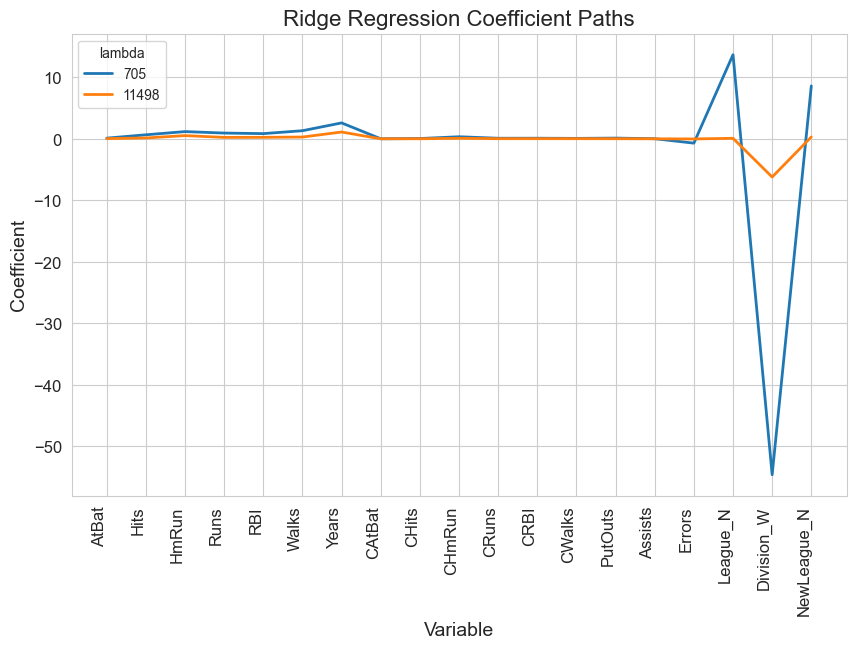

In [256]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=coef_ridge, x="Variable", y="Coefficient", hue="lambda", linewidth=2)
plt.xticks(rotation=90, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Coefficient", fontsize=14)
plt.title("Ridge Regression Coefficient Paths", fontsize=16)
plt.show()

## `predict()`

- We can use the `predict()` function for predictions.

In [257]:
ridge = skl.ElasticNet(l1_ratio=0., alpha=50 / y.std()).fit(Xs, y)

X_mean = X.mean(0).to_numpy()
X_std  = X.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()]),
    ridge.coef_ / X_std
))
ridge_coef

array([ 4.87387816e+01, -3.52687751e-01,  1.95185328e+00, -1.27211597e+00,
        1.15367125e+00,  8.07363172e-01,  2.70102626e+00, -6.11882862e+00,
        6.02157282e-03,  1.05870955e-01,  6.20232944e-01,  2.16210666e-01,
        2.17006211e-01, -1.46932815e-01,  2.49675152e-01,  1.20392979e-01,
       -3.27266679e+00,  4.57810653e+01, -1.18011318e+02, -9.39391513e+00])

In [258]:
# np.dot(np.concatenate((np.ones((Xs.shape[0], 1)), X), axis=1), ridge_coef)[0:19]

In [259]:
ridge.predict(Xs)[0:19, ]

array([ 469.48722172,  662.58512687, 1021.96988538,  505.38615502,
        550.09578594,  199.68142005,   79.31604336,  104.48248874,
        836.35324509,  864.50464964,  241.86608544,  514.68001579,
        302.97772232,  385.07322355, 1080.68021948,   18.55408858,
        107.78550974,  483.06041971,  353.50530701])

In [260]:
ridge = skl.ElasticNet(l1_ratio=0., alpha=1e10 / y.std()).fit(Xs, y)

X_mean = X.mean(0).to_numpy()
X_std  = X.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()]),
    ridge.coef_ / X_std
))
ridge_coef

array([ 5.35925694e+02,  5.44346501e-08,  1.97458823e-07,  7.95652107e-07,
        3.33917759e-07,  3.52722099e-07,  4.15132209e-07,  1.69771086e-06,
        4.67374204e-09,  1.72007054e-08,  1.29717051e-07,  3.45084546e-08,
        3.56134815e-08,  3.76787718e-08,  2.18028795e-08,  3.56119834e-09,
       -1.66046019e-08, -5.80026272e-07, -7.80726333e-06, -1.15228774e-07])

In [261]:
ridge.predict(Xs)[0:19, ]

array([535.92587825, 535.92590588, 535.92600575, 535.92580629,
       535.92591692, 535.92573956, 535.9257515 , 535.92576013,
       535.92600742, 535.9259994 , 535.92580018, 535.92585767,
       535.925795  , 535.92583921, 535.92607729, 535.92574378,
       535.92575827, 535.92583405, 535.92581147])

- We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso.

In [262]:
# Split the data into training and test sets
np.random.seed(20231107)
train = np.random.choice(range(X.shape[0]), size=int(X.shape[0] / 2), replace=False)
X_train = X.iloc[train, :]
X_test  = X.iloc[~np.isin(np.arange(X.shape[0]), train), :]

# Compute mean and standard deviation from the training set
mu_tr = X_train.mean(0)
sd_tr = X_train.std(0)
sd_tr = sd_tr.replace(0, 1.0)  # Prevent division by zero if a column has zero variance

# Standardize training features using training mean and std
Xs_train = (X_train - mu_tr) / sd_tr

# Standardize test features using the same training mean and std
# (Never standardize test data using its own statistics!)
Xs_test = (X_test - mu_tr) / sd_tr

# Split the target variable accordingly
y_train = y.iloc[train]
y_test  = y.iloc[~np.isin(np.arange(X.shape[0]), train)]

- When $\lambda$ is large, all parameters have small absolute values due to strong penalty. The result will be close to the one obtained by fitting only an intercept term

In [202]:
#X_train.mean(0)[None,:], X_test.mean(0)[None,:], Xs_train_scale[None,:], Xs_test_scale[None,:]

In [263]:
ridge = skl.ElasticNet(l1_ratio=0.,alpha=1e10/(y_train.std())).fit(Xs_train,y_train)
ridge_pred = ridge.predict(Xs_test)

In [264]:
# Compute the coefficients on the original (unstandardized) scale
X_mean = X_train.mean(0).to_numpy()
X_std  = X_train.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()]),
    ridge.coef_ / X_std
))

# Make manual predictions on the test set (add a column of ones for intercept)
pred_manual = np.dot(
    np.concatenate((np.ones((X_test.shape[0], 1)), X_test.to_numpy()), axis=1),
    ridge_coef
)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(((pred_manual - y_test.to_numpy()) ** 2).mean())
rmse

np.float64(454.70285385507026)

In [265]:
#Fit only the intercept term; ridge regression
np.sqrt(((y_train.mean() - y_test)**2).mean()), np.sqrt(((ridge_pred - y_test)**2).mean())

(np.float64(454.7029112030767), np.float64(454.7028538550702))

- When $\lambda$ is small, all parameters will tend to the LSE due to mild penalty.

In [266]:
ridge = skl.ElasticNet(l1_ratio=0.,alpha=1/(y_train.std())).fit(Xs_train,y_train)
ridge_pred = ridge.predict(Xs_test)
np.sqrt(((ridge_pred - y_test)**2).mean())

np.float64(296.13898711056913)

In [267]:
# The predictions from the model after unstandardization
X_mean = X_train.mean(0).to_numpy()
X_std  = X_train.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()]),
    ridge.coef_ / X_std
))

pred_manual = np.dot(
    np.concatenate((np.ones((X_test.shape[0], 1)), X_test.to_numpy()), axis=1),
    ridge_coef
)

rmse = np.sqrt(((pred_manual - y_test.to_numpy())**2).mean())
rmse

np.float64(296.1389871105691)

- When $\lambda = 0$, the results are expected to be exactly the same as that of linear regression.

In [268]:
ridge = skl.ElasticNet(l1_ratio=0.,alpha=0/(y_train.std())).fit(Xs_train,y_train)
ridge_pred = ridge.predict(Xs_test)
np.sqrt(((ridge_pred - y_test)**2).mean())

np.float64(306.65756011310907)

In [269]:
# The predictions from the model after unstandardization
X_mean = X_train.mean(0).to_numpy()
X_std  = X_train.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()]),
    ridge.coef_ / X_std
))

pred_manual = np.dot(
    np.concatenate((np.ones((X_test.shape[0], 1)), X_test.to_numpy()), axis=1),
    ridge_coef
)

rmse = np.sqrt(((pred_manual - y_test.to_numpy())**2).mean())
rmse

np.float64(306.6575601131091)

In [270]:
ridge_coef

array([ 2.33017349e+02, -1.51875016e+00,  4.59735930e+00,  5.14620184e+00,
        2.57214867e+00, -1.89349444e+00,  1.77354173e+00,  1.44100942e+01,
       -4.97027082e-01,  1.50296692e+00,  2.12449441e+00,  6.44713726e-01,
        2.13446891e-01, -5.04251442e-01,  3.18424447e-01,  4.70946564e-01,
       -4.65480361e+00,  7.96077951e+01, -1.31125803e+02, -4.78949188e+01])

In [271]:
pred_manual[0:19]

array([611.9137752553224, 332.56885712736636, 124.37142842219353,
       922.6240538527428, 249.56659171187937, 403.1448334150649,
       326.63266438883693, 427.7844949029749, 195.817089135743,
       473.49107434827687, 577.3365956918577, 568.383249591748,
       259.79394896041754, 296.8461770765507, 379.4918664912236,
       493.48993359503874, 895.212975089401, 206.73414180185972,
       250.06141429526764], dtype=object)

In [272]:
ridge_pred = ridge.predict(Xs_test)

In [273]:
ridge_pred[0:19]

array([611.91377526, 332.56885713, 124.37142842, 922.62405385,
       249.56659171, 403.14483342, 326.63266439, 427.7844949 ,
       195.81708914, 473.49107435, 577.33659569, 568.38324959,
       259.79394896, 296.84617708, 379.49186649, 493.4899336 ,
       895.21297509, 206.7341418 , 250.0614143 ])

- The above predictions derived from `.predict()` and manual unstandardization are different, which are expected, since the mean and variance of test data and train data are not exactly the same.

In [274]:
reg = skl.LinearRegression().fit(X_train, y_train)

In [275]:
reg.intercept_, reg.coef_

(np.float64(230.81188252184518),
 array([  -1.48872358,    4.4794937 ,    5.03736263,    2.65506393,
          -1.8638036 ,    1.7190234 ,   15.21145397,   -0.51195039,
           1.57280583,    2.2354418 ,    0.60296319,    0.17184527,
          -0.48601012,    0.3176502 ,    0.47527567,   -4.73677401,
          80.72788169, -131.1494012 ,  -48.6486961 ]))

In [276]:
reg.predict(X_test)[0:19]

array([610.23264051, 326.02986299, 124.5193146 , 922.75386011,
       248.69301826, 400.88672793, 330.5406299 , 428.04608289,
       193.99553556, 474.27224644, 575.62971745, 567.94246448,
       259.75465489, 295.52126211, 379.34822949, 491.3671128 ,
       896.63181344, 209.49407946, 249.87250768])

- `LinearRegression()` and `ElasticNet()` results are not exactly equivalent because `ElasticNet()` applies a coordinate descent algorithm.

## Let's simply visualize the coefficients!

    Variable  Coefficient     Method
0  Intercept   233.017349  ElaticNat
1      AtBat    -1.518750  ElaticNat
2       Hits     4.597359  ElaticNat
3      HmRun     5.146202  ElaticNat
4       Runs     2.572149  ElaticNat


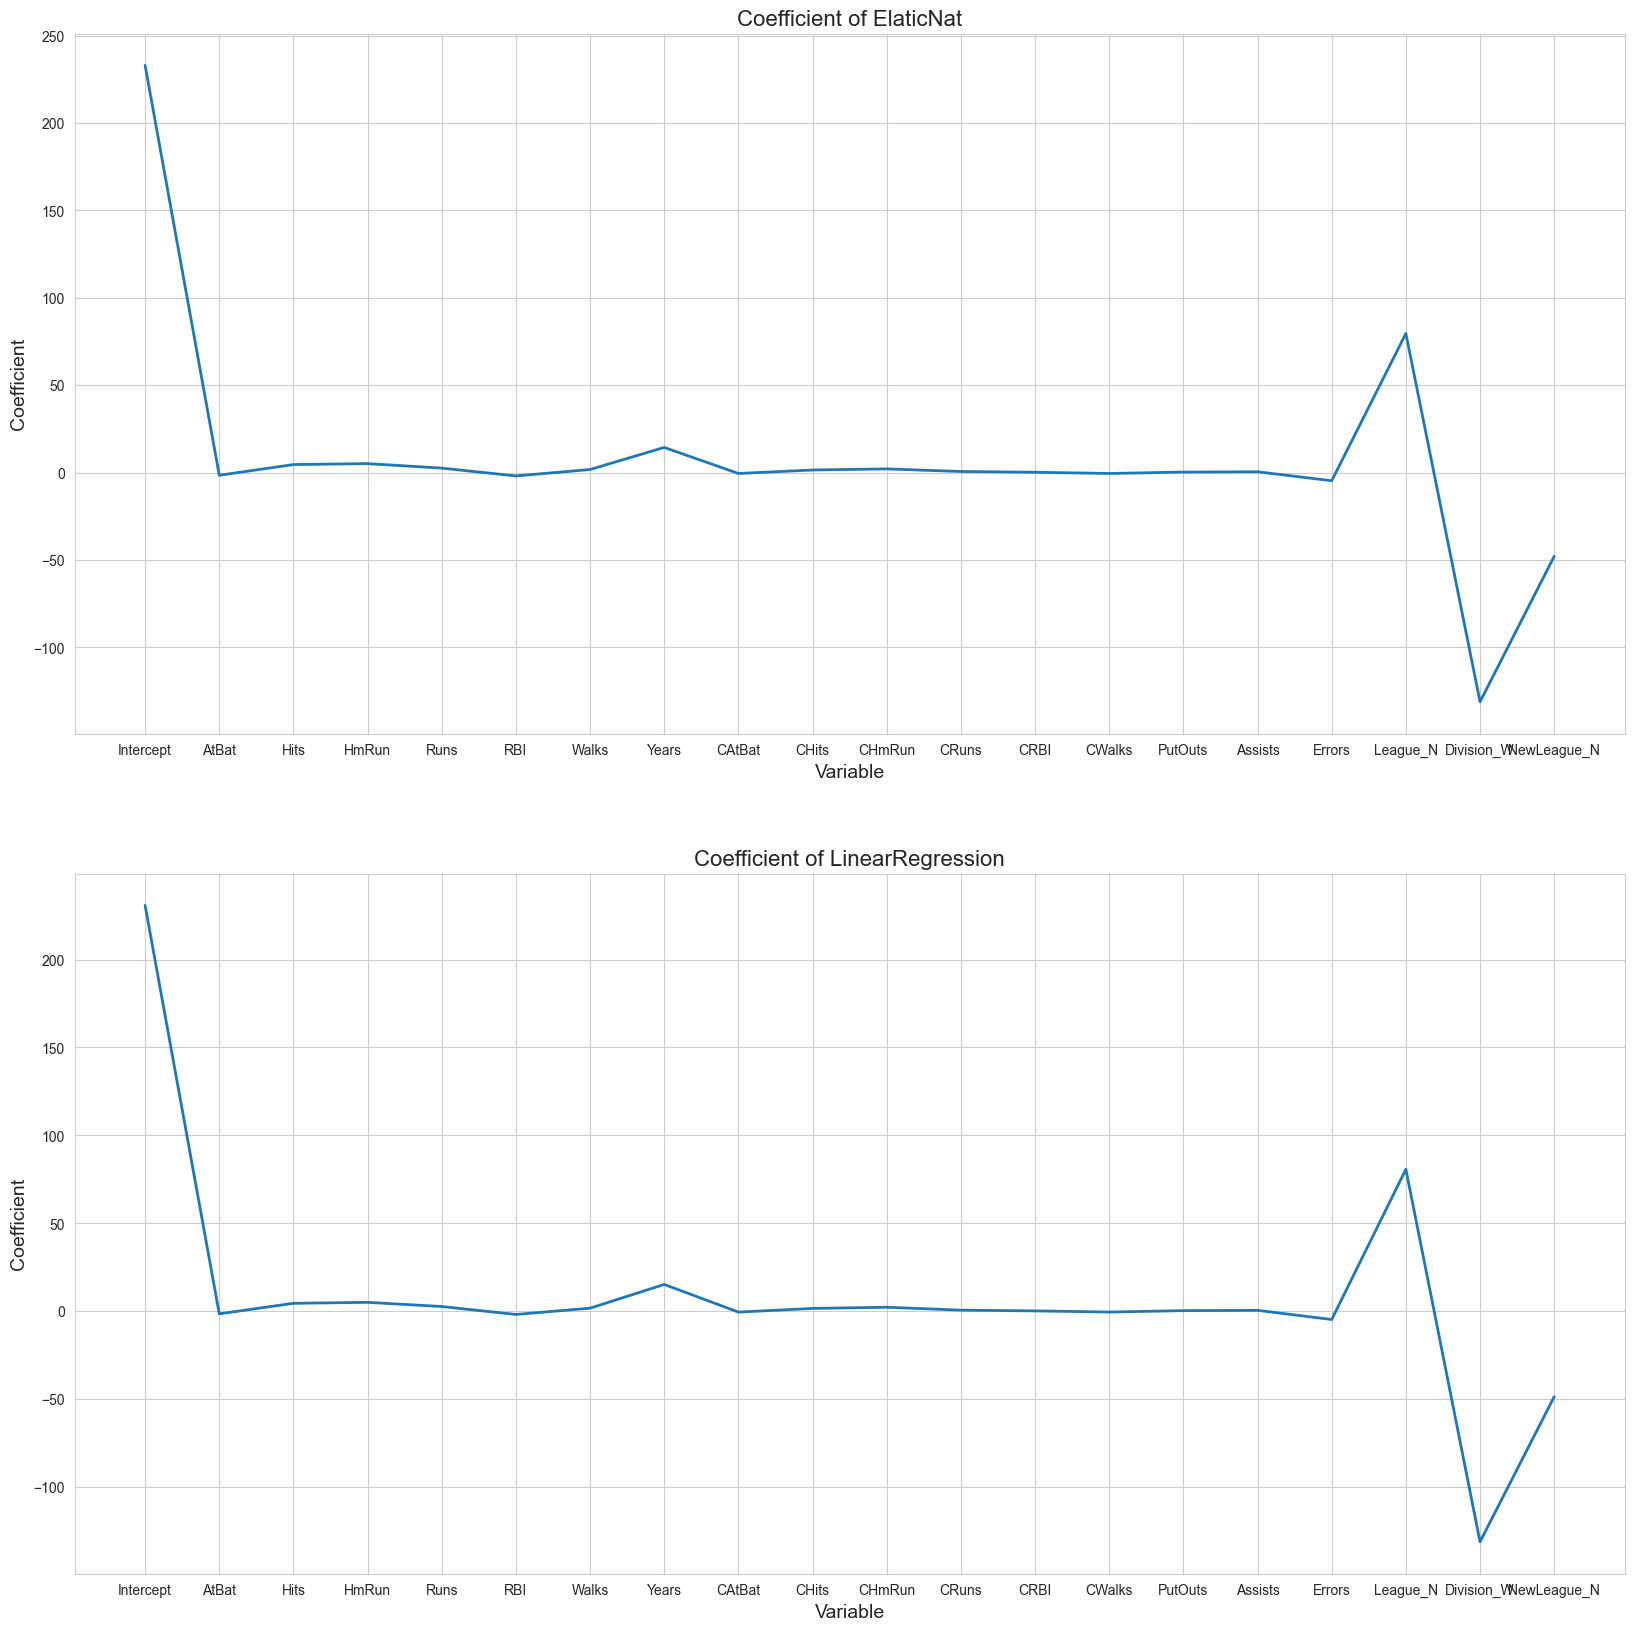

In [277]:
coef_ridge_lr = pd.DataFrame({
    "Variable": np.concatenate([list(['Intercept']), list(X.columns), list(['Intercept']), list(X.columns)]),
    "Coefficient": np.concatenate([ridge_coef, np.array([reg.intercept_]), reg.coef_]),
    "Method": np.repeat(['ElaticNat', 'LinearRegression'], 20)
})

# Round the lambda values and convert to factor
coef_ridge_lr["Method"] = coef_ridge_lr["Method"].astype("category")

# Print the first few rows
print(coef_ridge_lr.head())


fig, axs = plt.subplots(2, figsize=(20, 20))

flag = 0
for method, group in coef_ridge_lr.groupby("Method"):
    axs[flag].plot(group["Variable"], group["Coefficient"], label=method, linewidth=2)
    axs[flag].set_xlabel("Variable", fontsize=14)
    axs[flag].set_ylabel("Coefficient", fontsize=14)
    axs[flag].set_title("Coefficient of {}".format(method), fontsize=16)
    flag = flag + 1
                         

- In general, instead of arbitrarily choosing $\lambda$, it would be better to use cross-validation to choose the tuning parameter $\lambda$.
- We can do this using the built-in cross-validation function, `ElasticNetCV()`.
- By default, the function `ElasticNetCV()` performs __five-fold__ cross-validation, though this can be changed using the argument `cv`.

In [278]:
ridgecv = skl.ElasticNetCV(l1_ratio=0., alphas = grid/(y_train.std())).fit(Xs_train,y_train)
ridgecv

,l1_ratio,0.0
,eps,0.001
,n_alphas,'deprecated'
,alphas,array([2.2346...23461568e-05])
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,cv,None
,copy_X,True
,verbose,0


In [279]:
ridgecv.alpha_ # the penalized parameter chosen by cross-validation

np.float64(1.5764771860031803)

- Therefore, we see that the value of $\lambda$ that results in the smallest crossvalidation error is 1.5764771860031803.
- We can obtain the test MSE for this $\lambda$.

In [280]:
ridgecv_pred = ridgecv.predict(Xs_test)
np.sqrt(((ridgecv_pred - y_test)**2).mean())

np.float64(328.48834877928914)

In [281]:
# The predictions from the model after unstandardization
X_mean = X_train.mean(0).to_numpy()
X_std  = X_train.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridgecv.intercept_ - (X_mean * ridgecv.coef_ / X_std).sum()]),
    ridgecv.coef_ / X_std
))

pred_manual = np.dot(
    np.concatenate((np.ones((X_test.shape[0], 1)), X_test.to_numpy()), axis=1),
    ridge_coef
)

rmse = np.sqrt(((pred_manual - y_test.to_numpy())**2).mean())
rmse

np.float64(328.48834877928914)

In [282]:
ridge_coef

array([ 1.41739329e+02,  9.79165681e-02,  5.76607552e-01,  1.86428102e+00,
        9.85657392e-01,  8.05991063e-01,  8.76877055e-01,  1.93486825e+00,
        8.54751384e-03,  3.82181469e-02,  3.46709812e-01,  7.65739006e-02,
        8.76775399e-02,  4.70875717e-02,  1.08947702e-01, -5.38314939e-02,
       -1.20731150e+00,  8.84221312e+00, -5.68908004e+01,  5.37775139e+00])

- It outperforms the model with only the intercept.
- Finally, we refit the model using the best $\lambda$. 

In [283]:
ridge = skl.ElasticNet(l1_ratio=0.,alpha=ridgecv.alpha_).fit(Xs,y)
X_mean = X.mean(0).to_numpy()
X_std  = X.std(0).to_numpy()

ridge_coef = np.concatenate((
    np.array([ridge.intercept_ - (X_mean * ridge.coef_ / X_std).sum()]),
    ridge.coef_ / X_std
))
ridge_coef

array([ 5.57474618e+01,  1.11861556e-01,  6.53138832e-01,  1.17902239e+00,
        9.34670292e-01,  8.45164055e-01,  1.31526356e+00,  2.59371809e+00,
        1.08167775e-02,  4.66427687e-02,  3.37039010e-01,  9.32528434e-02,
        9.73972476e-02,  7.17092913e-02,  1.17938664e-01,  1.59884375e-02,
       -6.97354250e-01,  1.35916924e+01, -5.43670202e+01,  8.57412846e+00])

In [284]:
pred_manual = np.dot(np.concatenate((np.ones((X.shape[0], 1)), X), axis=1), ridge_coef)
np.sqrt(((pred_manual - y)**2).mean())

np.float64(336.7382472293154)

## LASSO `l1_ratio = 1`

In [285]:
lasso_coef = np.zeros((1+X.shape[1], len(grid))) # store the coefficients for intercept and predictor variables

for i in np.arange(len(grid)):
    lasso = skl.ElasticNet(l1_ratio=1.,alpha=grid[i]/y_train.std()).fit(X_train, y_train)
    lasso_coef[0, i] = lasso.intercept_
    lasso_coef[1:lasso_coef.shape[0], i] = lasso.coef_

In [286]:
lasso_coef.shape

(20, 100)

In [287]:
lasso_path = pd.DataFrame({'coefficients' : lasso_coef[1:,].reshape(1,-1)[0], 
             'variables' : np.repeat(X.columns.to_numpy(), len(grid)),
             'lambdas' : np.tile(grid/y_train.std(), lasso_coef.shape[0]-1),
             'L1 norm' : np.tile(np.abs(lasso_coef[1:,]).sum(0), lasso_coef.shape[0]-1)})
lasso_path.head()

,coefficients,variables,lambdas,L1 norm
0,0.0,AtBat,2.234616e+07,0.0
1,0.0,AtBat,1.690405e+07,0.0
2,0.0,AtBat,1.278729e+07,0.0
3,0.0,AtBat,9.673118e+06,0.0
4,0.0,AtBat,7.317359e+06,0.0


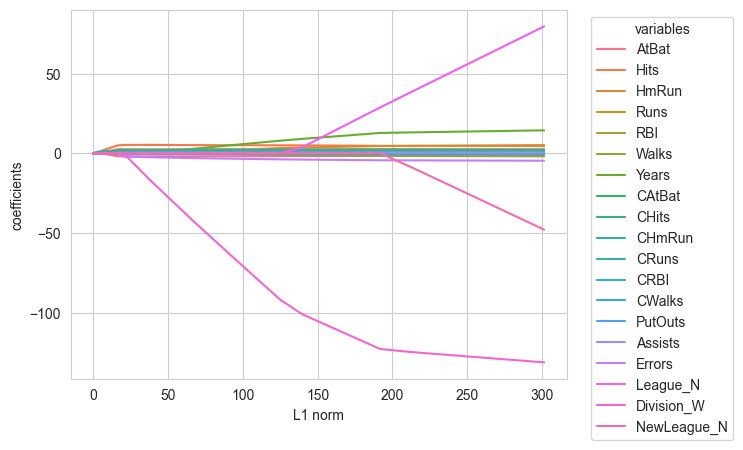

In [288]:
ax = sns.lineplot(data = lasso_path, x = 'L1 norm', y = 'coefficients', hue = 'variables', legend = 'brief')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.35, 1))
plt.show()

- We now perform cross-validation and compute the associated test error.

In [289]:
lassocv = skl.ElasticNetCV(l1_ratio=1., alphas = grid/(y_train.std())).fit(X_train,y_train)
lassocv.alpha_ # the penalized parameter chosen by cross-validation

np.float64(2234.6156796030627)

In [290]:
lassocv_pred = lassocv.predict(X_test)
np.sqrt(((lassocv_pred - y_test)**2).mean())

np.float64(316.116495219622)

- This is substantially lower than the test set MSE of the null model, and very similar to the test MSE of ridge regression with λ chosen by cross-validation.
- However, the lasso has an advantage over ridge regression in that the resulting coefficient estimates are sparse (interpretability).

In [291]:
lasso = skl.ElasticNet(l1_ratio=1.,alpha=lassocv.alpha_).fit(X, y)
lasso.intercept_, lasso.coef_

(np.float64(22.559389231194814),
 array([ 0.52610263,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.17975982,  0.48999589,  0.        ,
         0.5176473 ,  0.47014893,  0.        ,  0.28388914,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        ]))

- More than half of the coefficients are shrinked to zeros!

## Comparison between Lasso and Ridge
- We already see that Lasso may not be better than Ridge.
- <font color='red'>Let's use simulation to analyze their performance when some true coefficients are zero, which means that Lasso is closer to the ground truth than Ridge.</font>
- Since automatic alpha grid generation is not supported for `l1_ratio=0`, we use `RidgeCV()` and `LassoCV()` respectively instead of `ElasticNet()`.

In [292]:
n = 100 # Training size
ntest = 500 # Test size
p = 500 # Number of predictor variables
p_nonzero = int(0.5 * 500) # Number of non-zero predictor variables
nrep = 30 # Repeat experiments 30 times

sb2 = 0.5
se2 = 1 - sb2

X = np.random.normal(size=(n, p)) / np.sqrt(p)
Xtest = np.random.normal(size=(ntest, p)) / np.sqrt(p)

beta = np.zeros(p)
beta[0:p_nonzero] = np.random.normal(0, np.sqrt(sb2 * p / p_nonzero), p_nonzero)

y0 = X.dot(beta)
ytest = Xtest.dot(beta)

beta_MSE = np.zeros((nrep, 2))
pred_MSE = np.zeros((nrep, 2))

for irep in range(nrep):
    y = y0 + np.random.normal(0, np.sqrt(se2), n)

    ridge = skl.RidgeCV().fit(X,y)
    lasso = skl.LassoCV().fit(X,y)

    parameters = {'alpha': [0.0, 1.0]}

    beta_ridge = ridge.coef_
    beta_lasso = lasso.coef_
    beta_MSE[irep, 0] = ((beta - beta_ridge)**2).mean()
    beta_MSE[irep, 1] = ((beta - beta_lasso)**2).mean()

    pred_ridge = ridge.predict(Xtest)
    pred_lasso = lasso.predict(Xtest)

    pred_MSE[irep, 0] = ((ytest - pred_ridge)**2).mean()
    pred_MSE[irep, 1] = ((ytest - pred_lasso)**2).mean()

In [293]:
beta_MSE = pd.DataFrame(beta_MSE, columns=["Ridge", "Lasso"])
beta_MSE = pd.melt(beta_MSE, var_name="Method", value_name="MSE")

pred_MSE = pd.DataFrame(pred_MSE, columns=["Ridge", "Lasso"])
pred_MSE = pd.melt(pred_MSE, var_name="Method", value_name="MSE")

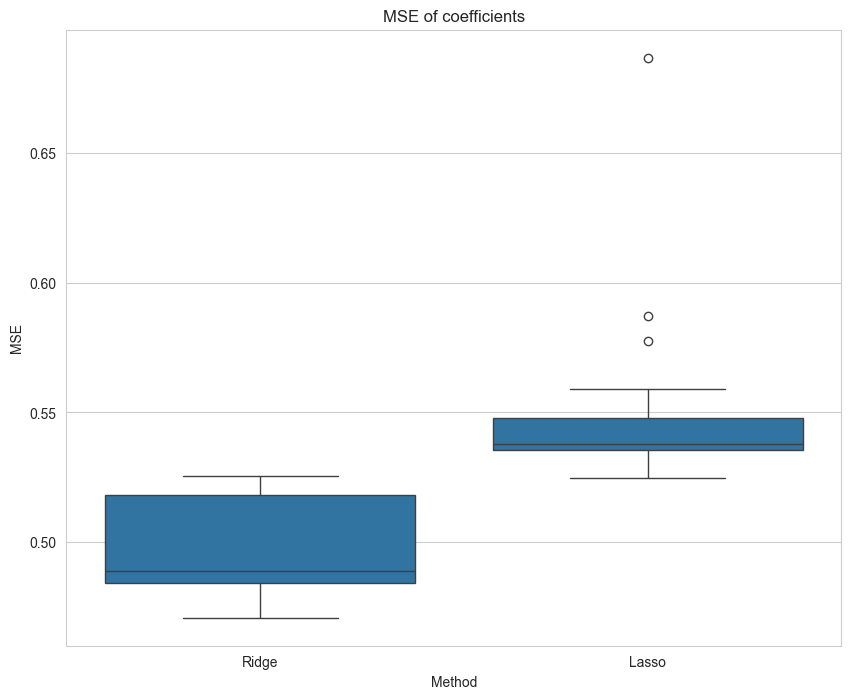

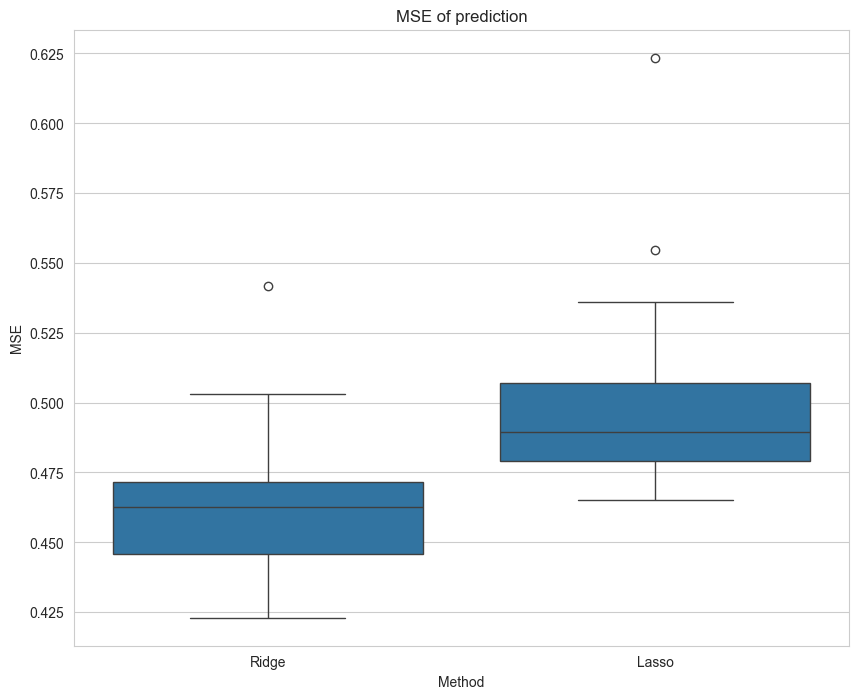

In [294]:
plt.figure(figsize=(10, 8))
plt.title("MSE of coefficients")
sns.boxplot(x="Method", y="MSE", data=beta_MSE)
plt.show()

plt.figure(figsize=(10, 8))
plt.title("MSE of prediction")
sns.boxplot(x="Method", y="MSE", data=pred_MSE)
plt.show()

Amazing! 
<font color='red'>In terms of both coefficients estimation and prediction accuracy, Ridge outperforms Lasso, which is expected to be a better method.</font>

Try to think about it!

Remember that we changed the <font color='red'>signal-to-noise ratio</font> (SNR or S/N) and compared the performances in the last tutorial.

This time we increase the <font color='red'>sample size</font> and reduce the <font color='red'>number of predictor variables</font>.

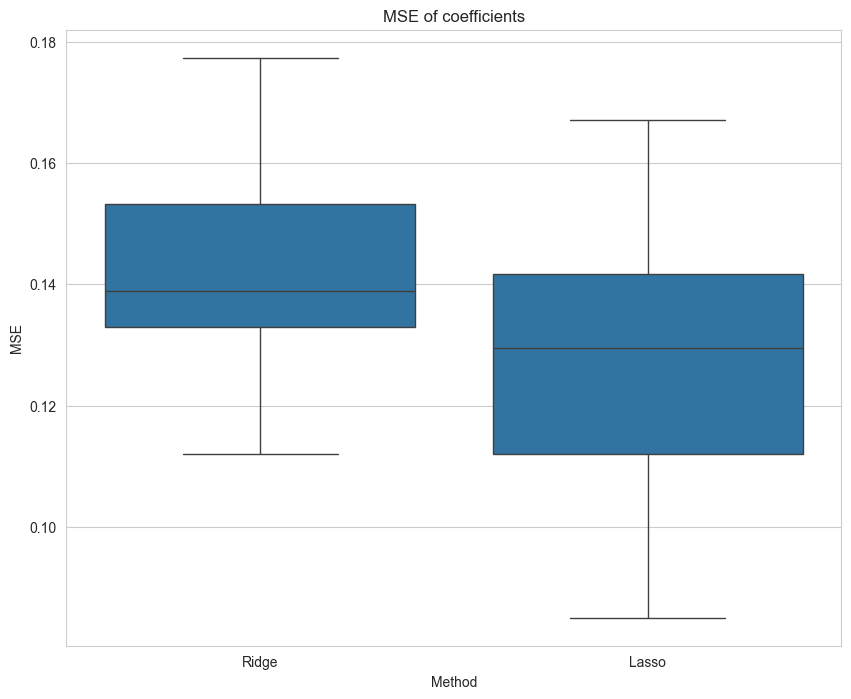

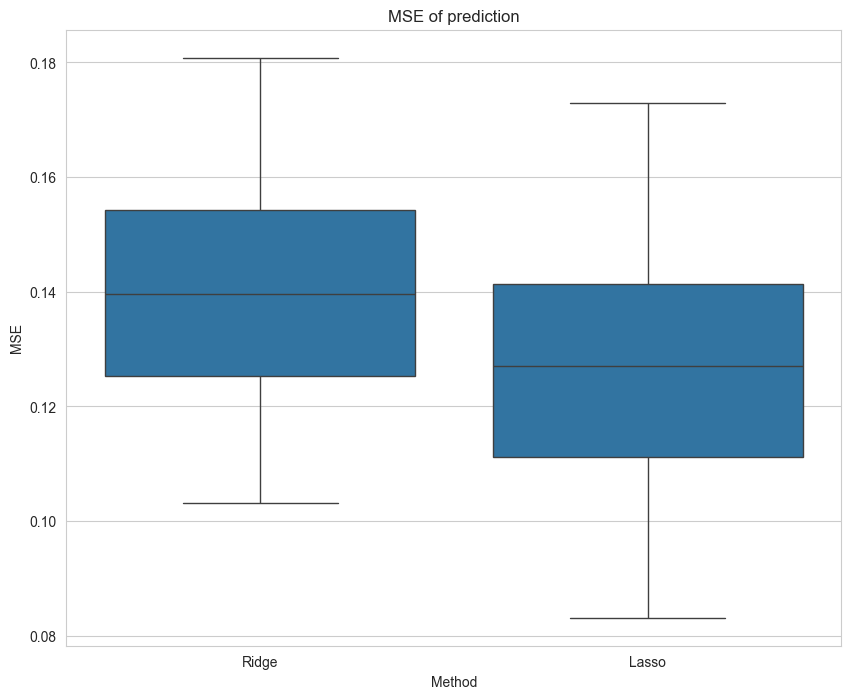

In [295]:
n = 300 # 100 -> 400
ntest = 500
p = 100 # 500 -> 100
p_nonzero = int(0.5 * p)
nrep = 30

sb2 = 0.5
se2 = 1 - sb2

X = np.random.normal(size=(n, p)) / np.sqrt(p)
Xtest = np.random.normal(size=(ntest, p)) / np.sqrt(p)

beta = np.zeros(p)
beta[0:p_nonzero] = np.random.normal(0, np.sqrt(sb2 * p / p_nonzero), p_nonzero)

y0 = X.dot(beta)
ytest = Xtest.dot(beta)

beta_MSE = np.zeros((nrep, 2))
pred_MSE = np.zeros((nrep, 2))

for irep in range(nrep):
    y = y0 + np.random.normal(0, np.sqrt(se2), n)

    ridge = skl.RidgeCV().fit(X,y)
    lasso = skl.LassoCV().fit(X,y)

    parameters = {'alpha': [0.0, 1.0]}

    beta_ridge = ridge.coef_
    beta_lasso = lasso.coef_
    beta_MSE[irep, 0] = ((beta - beta_ridge)**2).mean()
    beta_MSE[irep, 1] = ((beta - beta_lasso)**2).mean()

    pred_ridge = ridge.predict(Xtest)
    pred_lasso = lasso.predict(Xtest)

    pred_MSE[irep, 0] = ((ytest - pred_ridge)**2).mean()
    pred_MSE[irep, 1] = ((ytest - pred_lasso)**2).mean()
    
beta_MSE = pd.DataFrame(beta_MSE, columns=["Ridge", "Lasso"])
beta_MSE = pd.melt(beta_MSE, var_name="Method", value_name="MSE")

pred_MSE = pd.DataFrame(pred_MSE, columns=["Ridge", "Lasso"])
pred_MSE = pd.melt(pred_MSE, var_name="Method", value_name="MSE")

plt.figure(figsize=(10, 8))
plt.title("MSE of coefficients")
sns.boxplot(x="Method", y="MSE", data=beta_MSE)
plt.show()

plt.figure(figsize=(10, 8))
plt.title("MSE of prediction")
sns.boxplot(x="Method", y="MSE", data=pred_MSE)
plt.show()

<font color='red'>It's clear that the data quality (corresponding to the sample size here) plays a role!<\font>